In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./loo_pft.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, plot_performance, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
mfile = '../../checkpoint/latest/pretrainer.pt'
pretrainer = loadconceptor(mfile)

data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))

df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))[pretrainer.feature_name]
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [3]:
tmb_cohorts = ['IMVigor210', 'Rose', 'Liu', 'Riaz'] # larger cohorts in BLCA and SKCM

In [4]:
df_label = df_label[~df_label.real_TMB.isna()]
df_label = df_label[df_label.cohort.isin(tmb_cohorts)]
df_label['log2_TMB'] = np.log2(df_label.real_TMB + 1)
df_tpm = df_tpm.loc[df_label.index]

In [5]:
size = df_label.groupby('cohort').size()
size = size.index + "(n = " + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfg_score, dfc_score = pretrainer.extract(dfcx, batch_size=16)
dfc = dfc_score[dfc_score.columns.difference(['Reference'])]

100%|##########| 30/30 [00:04<00:00,  7.46it/s]


In [6]:
df_tmb = dfc['TMB'].to_frame(name='TMB score').join(df_label[['log2_TMB', 'cohort', 'cancer_type']]) 
df_tmb.cohort = df_tmb.cohort.map(size)

In [7]:
df_tmb.head()

,TMB score,log2_TMB,cohort,cancer_type
Index,,,,
IMVigor210-0257bb-ar-0257bbb,0.247796,4.247928,IMVigor210(n = 234),BLCA
IMVigor210-025b45-ar-025b45c,0.168329,1.000000,IMVigor210(n = 234),BLCA
IMVigor210-032c64-ar-032c642,0.293963,5.491853,IMVigor210(n = 234),BLCA
IMVigor210-0571f1-ar-0571f17,0.231509,1.584963,IMVigor210(n = 234),BLCA
IMVigor210-065890-ar-0658907,0.233928,3.169925,IMVigor210(n = 234),BLCA


In [8]:
#df_tmb.groupby('cohort').apply(lambda x:x.corr().loc['log2_TMB']['TMB score'])

In [9]:
df_tmb.cohort.unique()

array(['IMVigor210(n = 234)', 'Rose(n = 88)', 'Liu(n = 107)',
       'Riaz(n = 46)'], dtype=object)

In [10]:
def annotate(data, ax):
    import scipy as sp
    r, p = sp.stats.pearsonr(data['TMB score'], data['log2_TMB'])

    ax.text(.05, .92, "Pearson's $r$={:.2f}, $p$={:.2g}".format(r, p),
            transform=ax.transAxes)
c = sns.palettes.color_palette('bright', 10)
c

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

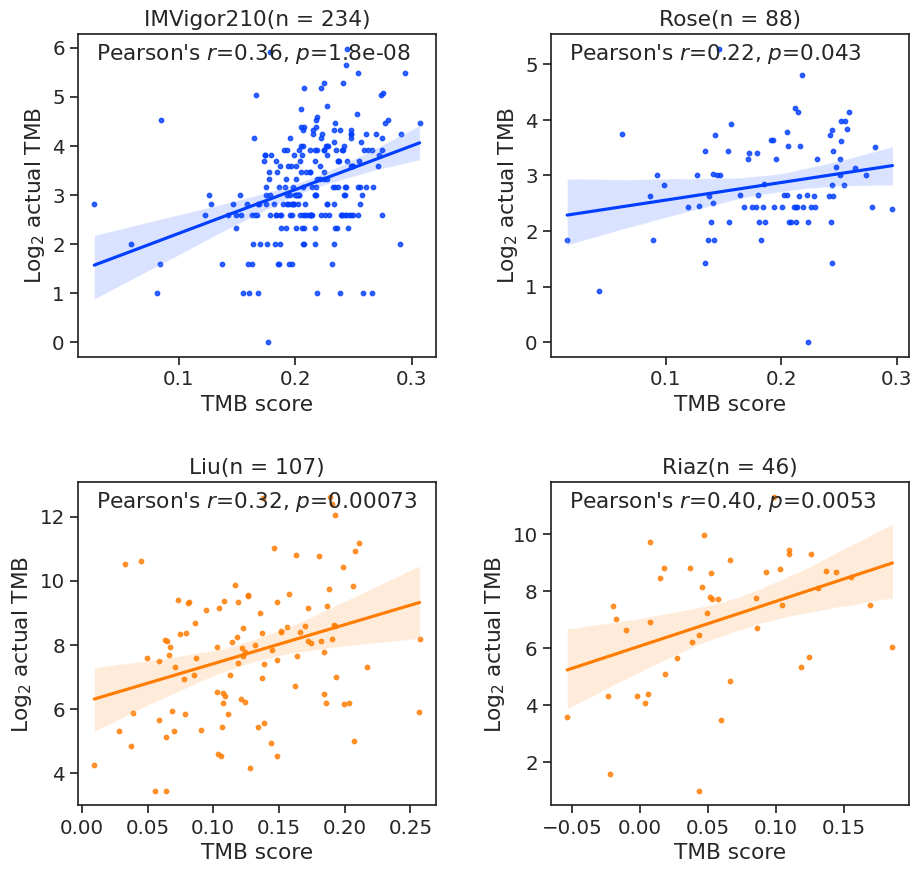

In [11]:
fig, axes = plt.subplots(figsize=(9.5, 9), ncols=2, nrows=2)
(ax1, ax2), (ax3, ax4) = axes
axes = [ax1, ax2, ax3, ax4]
colors = [c[0], c[0], c[1], c[1]]

for cohort, ax, color in zip(df_tmb.cohort.unique(), axes, colors):
    dft = df_tmb[df_tmb.cohort == cohort]
    sns.regplot(dft, x = 'TMB score', y = 'log2_TMB', ax=ax, 
                color = color, 
                scatter_kws={'s':10})
    ax.set_title(cohort)
    annotate(dft, ax)
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_ylabel('Log$_2$ actual TMB')

fig.tight_layout(h_pad=2, w_pad=2)

fig.savefig('./ITRP_TMBscore_vs_actualTMB.pdf')

In [12]:
df_tmb.to_csv('./ITRP_TMBscore_vs_actualTMB.csv')

In [13]:
import scipy as sp

In [14]:
# TMB feature(conceptor, p = 32)
# TMB score(conceptor, p = 1)
# TMB score(average, p = 1)
# TMB score(ssGSEA, p = 1)
# actual-TMB(p=1)

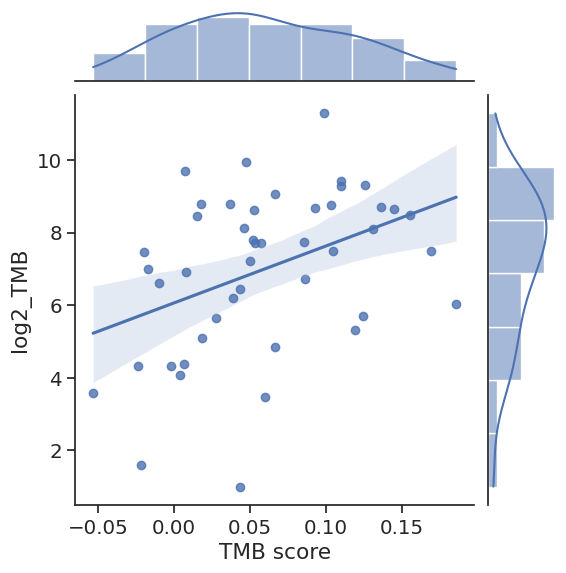

In [15]:
g = sns.jointplot(x="TMB score", y="log2_TMB", data=dft, kind="reg")
x_axis = g.fig.axes[0]
x_axis.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)